In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from iminuit import cost,Minuit
from jacobi import propagate

In [2]:
plt.rcParams.update({
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.labelsize': 9,
    'ytick.labelsize': 9
})
plt.style.use('seaborn-v0_8-colorblind')

In [3]:
#Reading in peaks from peak_selection_3hr_run
s2_peaks = np.load("C:/Users/keert/data_3hr_run/s2_run_3hr.npy",allow_pickle=True)
se_peaks1 = np.load("C:/Users/keert/data_3hr_run/se_run_3hr.npy",allow_pickle=True)
se_peaks2 = np.load("C:/Users/keert/data_3hr_run/ne_run_3hr.npy",allow_pickle=True)

se_peaks = np.sort(np.concatenate((se_peaks1, se_peaks2)), order='time')
print("number of s2_peaks:", len(s2_peaks))
print("number of se_peaks:", len(se_peaks))

number of s2_peaks: 72767
number of se_peaks: 1947132


# Associating SEs with previous S2- including double scatters

In [4]:
def diffs_s2_to_se(s2_peaks,se_peaks):
    """Assign each se peak to the s2 that comes directly before it in time
    
    s2_peaks = input array of S2 signals with a "time" column 
    se_peaks = input array of SE signals with a "time" column

    Returns three arrays:
    1. The indices of the S2s that each SE has been assigned to
    2. The time differences between each SE and the S2 directly before it
    3. An array of all SE peaks that have been assigned to an S2
    """
    assigned_indices = np.searchsorted(s2_peaks["time"], se_peaks["time"]) - 1
    valid_indices = assigned_indices[assigned_indices>= 0]                      #basically remove the SEs at the beginning of the run
                                                                                #since otherwise this algorithm would assign it to the S2 at
                                                                                #the end of the run
    se_no_s2 = len(assigned_indices) - len(valid_indices)
    time_diffs = se_peaks["time"][se_no_s2:]-s2_peaks["time"][valid_indices]   #find difference in time of each S2-se pair
    assigned_se_peaks = se_peaks[se_no_s2:]                                    #all se peaks after an S2 in the run
    return valid_indices,time_diffs,assigned_se_peaks

assigned_se_indices,time_diffs_se,se_peaks= diffs_s2_to_se(s2_peaks,se_peaks)   #finding time differences (in ns)
print("no. of SE peaks assigned to an S2:",len(se_peaks))

#----------------
#NOTE: these following are just some metrics I experimented with to explore the dataset
#When plotting rate of electrons w.r.t area or width for example, can choose to see
#how many SEs within 100s, or SEs overall, or total area of all SEs etc. 


#find how many SEs are associated with each S2 within 100ms (to prevent bias from longer time windows)
se_per_s2_100ms = np.zeros(len(s2_peaks))                          

for se_index, s2_index in enumerate(assigned_se_indices):
    if time_diffs_se[se_index] < 100e6:                          #Remove this to include all SEs
        if time_diffs_se[se_index] > 6.9e6:                      #to only include delayed component
            se_per_s2_100ms[s2_index] += 1


livetime_windows = np.diff(s2_peaks["time"])*1e-6                         #time between S2s in ms
livetime_windows = np.append(livetime_windows,np.nan)                     

assigned_se_rate = se_per_s2_100ms   

#----------------
#finding total area of assigned SEs per S2
se_totals = np.zeros(len(s2_peaks))
for se_index, s2_index in enumerate(assigned_se_indices):
    # Add the value from the second column of se_peaks to the corresponding s2_peak sum
    if time_diffs_se[se_index] < 100e6:                                #just remove this to include all SEs
        if time_diffs_se[se_index] > 6.9e6:                            #to only include delayed component
            se_totals[s2_index] += se_peaks[se_index]["area"]

#----------------
#saving the indices and time differences in an updated s2_peaks dataframe and se_peaks array
#using dataframes here because cant add columns to structured arrays
s2_peaks_assigned = pd.DataFrame(s2_peaks)
s2_peaks_assigned["livetime windows"] = livetime_windows
s2_peaks_assigned["assigned SE rate"] = assigned_se_rate
s2_peaks_assigned["SE area total"] = se_totals
#total assigned SEs per S2- includes bias from different time windows
s2_peaks_assigned["total SE"] = np.bincount(assigned_se_indices)

se_peaks_assigned = pd.DataFrame(se_peaks)
se_peaks_assigned["S2 index"] = assigned_se_indices             #index of the S2 that the SE has been associated with
se_peaks_assigned["time differences"] = time_diffs_se           #time difference between SE and S2 directly before it in ns

s2_peaks_assigned["time since start"] = s2_peaks_assigned["time"] - s2_peaks_assigned["time"].iloc[0]   #in ns
se_peaks_assigned["time since start"] = se_peaks_assigned["time"] - s2_peaks_assigned["time"].iloc[0]   #in ns


livetime_windows_exc_ds = livetime_windows[livetime_windows>2.3]          #excluding double scatters

print("mean livetime with double scatter (ms):",np.nanmean(livetime_windows),"+-",np.std(livetime_windows))
print("mean livetime without double scatter (ms):",np.mean(livetime_windows_exc_ds))
print("no. of S2s excluding double scatter:",len(livetime_windows_exc_ds))



no. of SE peaks assigned to an S2: 1947101
mean livetime with double scatter (ms): 148.45596801858014 +- nan
mean livetime without double scatter (ms): 229.68433178560792
no. of S2s excluding double scatter: 47026


In [5]:
print("fraction of data that is single scatters:",len(livetime_windows_exc_ds)*100/len(livetime_windows))

fraction of data that is single scatters: 64.62544834883944


# Investigating livetime windows

In [13]:
def expon_pdf(t, n, t_min):
    """Normalized exponential pdf with values below drift time set to zero
    
    t = array of times to evaluate the pdf at
    n = decay constant
    t_min = time below which pdf is zero"""
    t = np.asarray(t)
    pdf_values = np.full(t.shape,0.0)
    mask = t>=t_min
    pdf_values[mask] = n*np.exp(-n*(t[mask]-t_min))
    return pdf_values

def expon_pdf_ext(t, s, n, t_min):
    """Extended version of the normalized exponential pdf with values below drift time set to zero 
    
    t = array of times to evaluate the pdf at
    s = scale factor 
    n = decay constant
    t_min = time below which pdf is zero
    """
    pdf = expon_pdf(t, n, t_min)
    return s,s*pdf

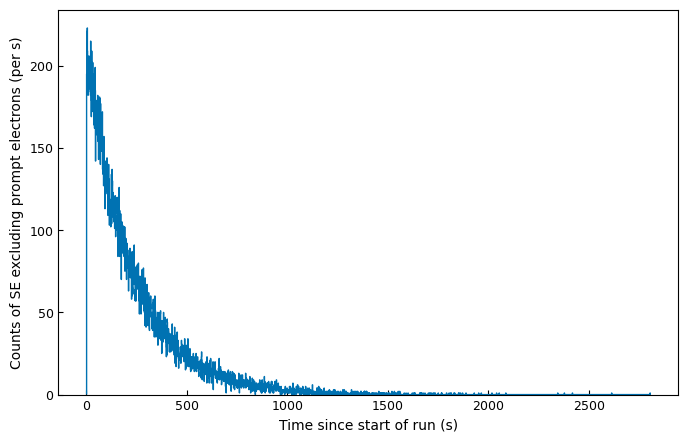

In [6]:
#visualizing livetime windows in a histogram excluding windows from double scatters

resolution_expon = 1          #bin size in milliseconds
n_bins = int((np.max(livetime_windows_exc_ds)-np.min(livetime_windows_exc_ds))/resolution_expon)

hist_expon, bin_edges_expon = np.histogram(livetime_windows_exc_ds, 
                                            bins=np.linspace(np.min(livetime_windows_exc_ds),np.max(livetime_windows_exc_ds),n_bins))
bin_centers_expon = (bin_edges_expon[:-1] + bin_edges_expon[1:])/2

fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.hist(bin_centers_expon,bins=bin_edges_expon,weights=hist_expon,histtype="step");
ax.set_xlabel("Time since start of run (s)")
ax.set_ylabel("Counts of SE excluding prompt electrons (per s)");

In [10]:
#fitting the exponential pdf to the live time windows excluding double scatters
c = cost.ExtendedUnbinnedNLL(livetime_windows_exc_ds,expon_pdf_ext)
m = Minuit(c,s=len(livetime_windows_exc_ds),
           t_min=2.3,n=5)

#Fixed t_min since we have cut the data to be exactly 2.3ms or more
#Otherwise double scatters gives huge false peak at the beginning
m.fixed["t_min"] = True 
bin_fit = m.values
m.interactive()
m.migrad()

/var/lib/condor/execute/dir_319422/ipykernel_319482/4104723637.py:6: RuntimeWarning: overflow encountered in exp
  pdf_values[mask] = n*np.exp(-n*(t[mask]-t_min))
/var/lib/condor/execute/dir_319422/ipykernel_319482/4104723637.py:12: RuntimeWarning: overflow encountered in multiply
  return s,s*pdf


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3.134e+05                 │              Nfcn = 118              │
│ EDM = 5.89e-08 (Goal: 0.0002)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  47.03e3  │  0.22e3   │            │            │         │         │       │
│ 1 │ n     │ 4.398e-3  │ 0.020e-3  │            │            │         │         │       │
│ 2 │ t_min │   2.300   │   0.023   │            │            │         │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │        s        n    t_min │
├───────┼────────────────────────────┤
│     s │  4.7e+04  -0.5e-9        0 │
│     n │  -0.5e-9 4.12e-10        0 │
│ t_min │        0        0        0 │
└───────┴────────────────────────────┘

In [7]:
a = np.load("C:/Users/keert/Downloads/Fit results/expon_fit.npy")
b = np.load("C:/Users/keert/Downloads/Fit results/expon_fit_cov.npy")
print(a,b)

[4.70260247e+04 4.39783802e-03 2.30000000e+00] [[ 4.70259614e+04 -4.63106095e-10  0.00000000e+00]
 [-4.63106095e-10  4.11735674e-10  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [8]:
s2_peaks_exc_peak1 = s2_peaks_assigned[s2_peaks_assigned["livetime windows"] > 2.3]  #all peaks + second peak of double scatters
#electrons assigned to this will include contribution from both this peak and the earlier scatter

s2_peaks_ds_peak1 = s2_peaks_assigned[s2_peaks_assigned["livetime windows"] <= 2.3]  #all double scatters first peak

s2_peaks_ds_peak2 = s2_peaks_assigned.loc[s2_peaks_ds_peak1.index + 1]              #all double scatters second peak

no_ds_index = s2_peaks_exc_peak1.index.difference(s2_peaks_ds_peak2.index) 
s2_peaks_exc_ds = s2_peaks_exc_peak1.loc[no_ds_index]                              #all S2s dropping double scatters altogether

assigned_se_exc_ds,time_diffs_exc_ds,se_peaks_exc_ds= diffs_s2_to_se(s2_peaks_exc_peak1.reset_index(),se_peaks)

In [9]:
print(len(s2_peaks_assigned.index))
print(len(s2_peaks_exc_peak1.index))
print(len(s2_peaks_ds_peak1.index))
print(len(s2_peaks_ds_peak2.index))
print(len(s2_peaks_exc_ds.index))

72767
47026
25740
25740
29286


frac. of se peaks within drift time:  0.4166111567915583
frac. of se peaks outside drift time:  0.5833888432084416


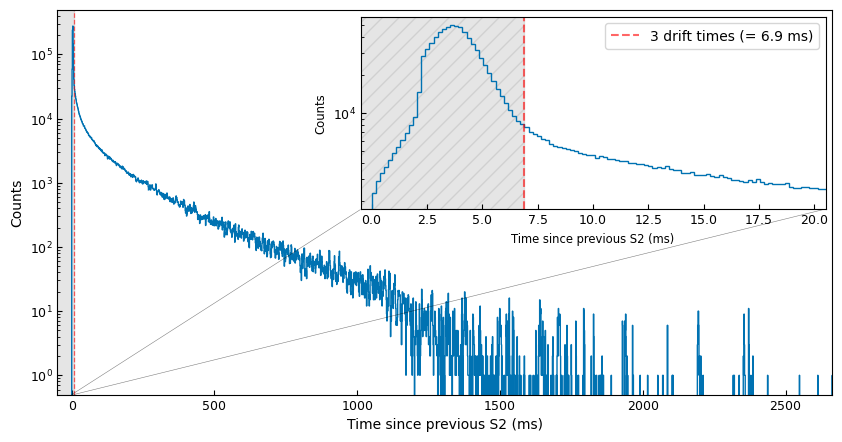

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.hist(time_diffs_exc_ds*1e-6,bins="auto",histtype="step")
ax.set_xlabel("Time since previous S2 (ms)")
ax.set_ylabel("Counts")
ax.set_yscale("log")
ax.set_xlim(-50,np.max(time_diffs_exc_ds*1e-6))


inset_axes = inset_axes(ax, width="60%", height="50%",loc="upper right") 

inset_axes.hist(time_diffs_exc_ds*1e-6,bins=np.linspace(0,25,135),histtype="step")
inset_axes.set_xlabel("Time since previous S2 (ms)",fontsize="small")
inset_axes.set_ylabel("Counts",fontsize="small")
inset_axes.axvline(x=6.9,color="red",label="3 drift times (= 6.9 ms)",linestyle="--",alpha=0.6)
inset_axes.set_yscale("log")
xmin, xmax = -0.5,20.5
inset_axes.set_xlim(xmin,xmax)


blocked_region = (-1, 6.9)  # Specify the start and end x-values to block out

# Add a shaded region to block out on the x-axis
inset_axes.axvspan(blocked_region[0], blocked_region[1],hatch='//', color='gray', alpha=0.2)
ax.axvline(x=6.9,color="red",label="3 drift times (= 6.9 ms)",linestyle="--",alpha=0.6,linewidth=0.9)
ax.axvspan(-100, blocked_region[1], color='gray', alpha=0.2)
inset_axes.legend()
ax.set_ylim(0.5,5e5)
ax.plot([0,1010],[0.5,3.8e2],linestyle="-",color="black",alpha=0.5,linewidth=0.4)
ax.plot([6.9,2630],[0.5,3.8e2],linestyle="-",color="black",alpha=0.5,linewidth=0.4)


#number of SE peaks that are less than and more than 6.3 ms of an S2 peak
print("frac. of se peaks within drift time: ",np.sum(time_diffs_se <= 6.9e6)/len(time_diffs_se))
print("frac. of se peaks outside drift time: ",np.sum(time_diffs_se >= 6.9e6)/len(time_diffs_se))
plt.savefig("prompt electrons cutoff",format="pdf")

In [10]:
pos_diffs_x = se_peaks["x_mlp"]-s2_peaks["x_mlp"][assigned_se_indices]
pos_diffs_y = se_peaks["y_mlp"]-s2_peaks["y_mlp"][assigned_se_indices]

#save the position differences in the se_peaks_assigned dataframe
se_peaks_assigned["x_pos differences"] = pos_diffs_x
se_peaks_assigned["y_pos differences"] = pos_diffs_y

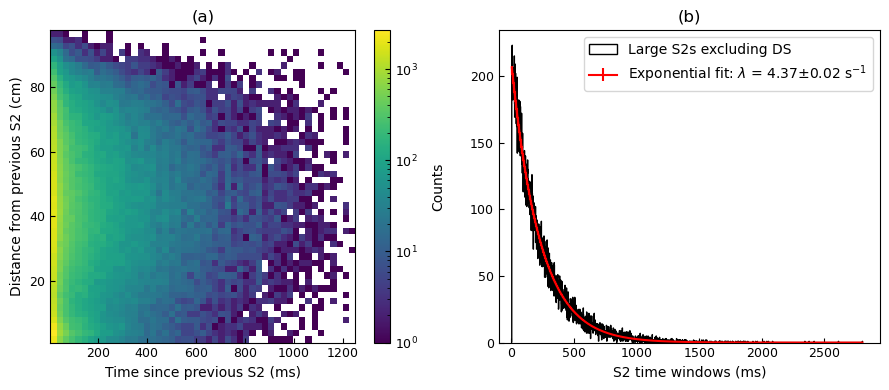

In [14]:
se_assigned_delayed = se_peaks_assigned[se_peaks_assigned["time differences"]*1e-6 > 6.9] 
se_assigned_delayed = se_assigned_delayed.dropna()

#Make a histogram for S2s located in the central region of the detector (r < 40 cm)
#and for SEs that are delayed by more than 2.3 ms
s2_central = s2_peaks_assigned[(s2_peaks["x_mlp"]**2 + s2_peaks_assigned["y_mlp"]**2)**0.5<30]
se_central = se_assigned_delayed[se_assigned_delayed["S2 index"].isin(s2_central.index)]

distance_to_s2_central = (se_central["x_pos differences"]**2 + se_central["y_pos differences"]**2)**0.5

fig, ax = plt.subplots(1,2,figsize=(9,4))
hist2d= ax[0].hist2d(se_central["time differences"]*1e-6,
           distance_to_s2_central,
           bins=(np.linspace(6.9,1250,50),
                 np.linspace(1,np.max(distance_to_s2_central),50)),
           cmap='viridis',norm=mcolors.LogNorm()
           );

#ax[0].colorbar(label='Counts')
ax[0].set_xlabel("Time since previous S2 (ms)")
ax[0].set_ylabel("Distance from previous S2 (cm)")
ax[0].set_title("(a)")
cbar = plt.colorbar(hist2d[3], ax=ax[0])
cbar.set_label('Counts',labelpad=10)


#plotting the livetime windows
def expon_model_val(t,p):
    s,n,t_min = p
    return expon_pdf_ext(bin_centers_expon,s,n,t_min)

model, model_errors = propagate(lambda p: expon_model_val(bin_centers_expon,p)[1],
                                a,b)

model_errors_prop = np.diag(model_errors)**0.5

ax[1].hist(bin_centers_expon,bins=bin_edges_expon,weights=hist_expon, histtype="step",color="k",label="Large S2s excluding DS")
ax[1].errorbar(bin_centers_expon,model*resolution_expon,yerr=model_errors_prop*resolution_expon,fmt="r",markersize=0.5,
           label=r"Exponential fit: $\lambda$ = 4.37$\pm$0.02 s$^{-1}$")
ax[1].set_xlabel("S2 time windows (ms)")
ax[1].set_xlim(-100,None)
ax[1].legend()
ax[1].set_title("(b)")
plt.tight_layout()


# Let's start fitting

In [15]:
#define basic functions to use for fitting in this cell
def constant_pdf_ext(t,s,t_min,t_max,s2_times):
    """Uniform continuous distribution everywhere except 6.9ms after each s2_peak
    where it is set to 0"""
    t = np.asarray(t)
    def segment1(t):
        return 1/(t_max-t_min)
    
    # Apply piecewise function for the PDF
    pdf = np.piecewise(t, 
                       [t < t_min, (t>=t_min) & (t<=t_max), t >= t_max], 
                       [0,segment1,0])
    #pretty rough coding: added this in because 6.9 sec after each peak does not have any data so 
    #I wanted the pdf to go to 0 there. To be improved- takes too long to run like this
    areas = np.array([])
    data_cut_end = s2_times + 6.9

    for x in range(len(s2_times)):
        mask = np.logical_and(t >= s2_times[x], t <= data_cut_end[x])
        pdf[mask] = 0
        to_remove = (data_cut_end.iloc[x] + s2_times.iloc[x])/(t_max-t_min)
        np.append(areas,to_remove)    
    
    return s,s*pdf/(1+np.sum(areas))
#----------------------

def power_law_pdf1(t,n,t_min):
    """Normalized power law pdf + some constant with all values below t_min set to zero"""
    t = np.asarray(t)                 
    pdf_values = np.full((t.shape),0.0)   #did this because otherwise it will calculate the pdf first which is a problem if t=0 is included
    mask = t>=t_min
    pdf_values[mask] = (((n-1)/t_min)*(t[mask]/t_min)**(-n))
    return pdf_values

def power_law_pdf_ext1(t,s,n,k,t_min):
    """Extended power law pdf + some constant with all values below t_min set to zero"""
    t = np.asarray(t)
    return s+k*(np.max(t)-t_min),s*power_law_pdf1(t,n,t_min)+k

#----------------------

def power_law_cdf(t,n,t_min):
    """Cumulative distribution function of power law distribution, clipped to make sure it doesn't go over 1
    Can use this for a binned  fit"""
    t = np.asarray(t)
    return (1-(t/t_min)**(-n+1)).clip(0,1)

def power_law_cdf_ext(t,s,n,t_min):
    """Extended cumulative distribution function of power law distribution, clipped to make sure it doesn't go over 1
    Can use this for a binned  fit"""
    t = np.asarray(t)
    return s*power_law_cdf(t,n,t_min)


In [16]:
se_delayed_peaks = se_peaks_assigned[se_peaks_assigned["time differences"] > 6.9e6]       #removing prompt electrons
print(len(se_delayed_peaks))

1135917


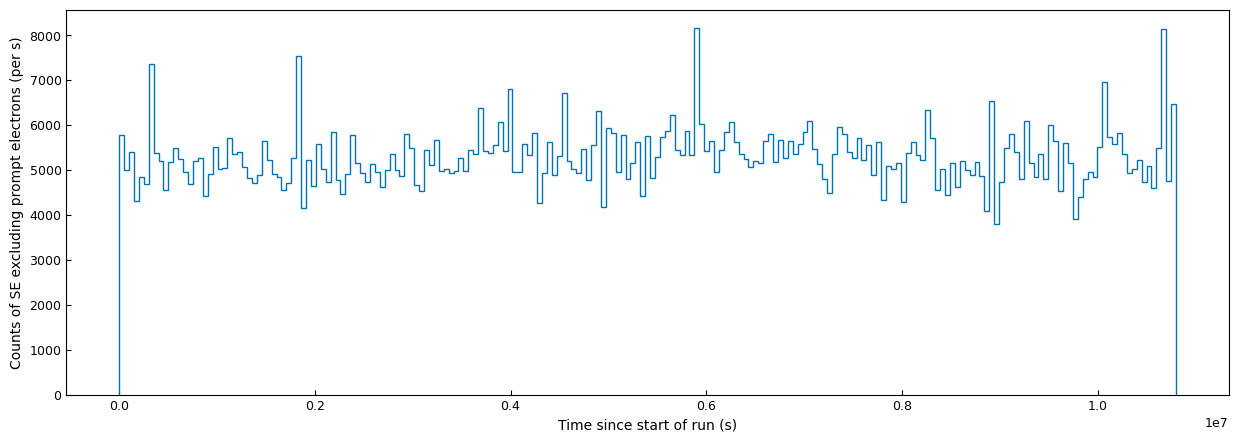

In [35]:
time_to_fit_const = se_delayed_peaks["time since start"]*1e-6      #in wall clock time

resolution_const_ms = 5e4
n_bins = int((np.max(time_to_fit_const)-np.min(time_to_fit_const))/resolution_const_ms)

hist_const, bin_edges_const = np.histogram(time_to_fit_const, 
                                            bins=np.linspace(np.min(time_to_fit_const),np.max(time_to_fit_const),n_bins))
bin_centers_const = (bin_edges_const[:-1] + bin_edges_const[1:])/2

#plotting just to check
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.hist(bin_centers_const,bins=bin_edges_const,weights=hist_const,histtype="step");
ax.set_xlabel("Time since start of run (s)")
ax.set_ylabel("Counts of SE excluding prompt electrons (per s)");


In [24]:
def to_fit_const(t,s,t_min,t_max):
    s2_times = s2_peaks_assigned["time since start"]*1e-3
    return constant_pdf_ext(t,s,t_min,t_max,s2_times)

In [30]:

c = cost.ExtendedUnbinnedNLL(time_to_fit_const,to_fit_const)
m = Minuit(c,s=len(time_to_fit_const),
           t_min=np.min(time_to_fit_const),t_max=np.max(time_to_fit_const))
m.limits["t_min"] = (6.9,np.max(time_to_fit_const))

#fixing t_max required to give a valid minimum- I assume due to normalization
m.fixed["t_max"] = True 

#m.interactive()         #call this last to play around with initial guesses
m.migrad()


/Software/users/modules/7/software/anaconda3/2023.03/lib/python3.10/site-packages/iminuit/util.py:1581: RuntimeWarning: Time limit 10 in smart sampling reached, produced 19 points
  warnings.warn(msg, RuntimeWarning)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.533e+06                  │              Nfcn = 44               │
│ EDM = 4.1e-05 (Goal: 0.0002)     │          time = 1858.7 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │ 1.1358e6  │ 0.0011e6  │            │            │         │         │       │
│ 1 │ t_min │  8.77849  │  0.00013  │            │            │   6.9   │1.08029e+07│       │
│ 2 │ t_max │  10.80e6  │  0.11e6   │            │            │         │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         s     t_min     t_max │
├───────┼───────────────────────────────┤
│     s │  1.14e+06 -4.773e-6         0 │
│ t_min │ -4.773e-6  1.61e-08         0 │
│ t_max │         0         0         0 │
└───────┴───────────────────────────────┘

In [42]:
a = np.load("C:/Users/keert/Downloads/Fit results/const_fit.npy")
b = np.load("C:/Users/keert/Downloads/Fit results/const_fit_cov.npy")

-0.008388949663824627
k: 0.10514092653945244 per ms


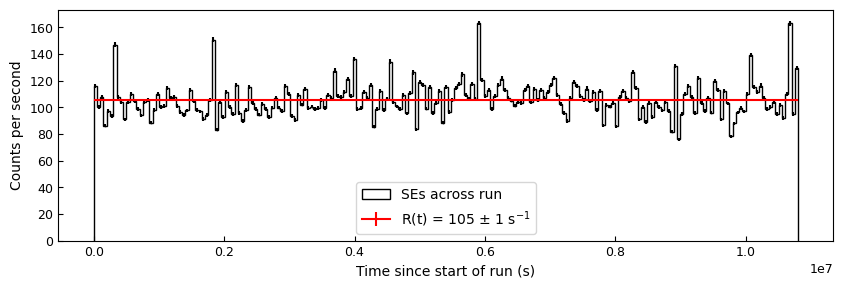

In [45]:
#plotting the fit
fig,ax = plt.subplots(1,1,figsize=(10,3))

def const_model_val(t,p):
    "Just a wrap around function to set the values of the variables"
    s,t_min,t_max = p
    return to_fit_const(bin_centers_const,s,t_min,t_max)

#propagating statistical uncertainties in the model to predictions
model, model_errors = propagate(lambda p: const_model_val(bin_centers_const,p)[1],
                                a,b)
model_errors_prop = np.diag(model_errors)**0.5

ax.hist(bin_centers_const,bins=bin_edges_const,weights=hist_const/50,histtype="step",color="k",label="SEs across run")
ax.errorbar(bin_centers_const,hist_const/50,yerr=np.sqrt(hist_const)/50,fmt="o",markersize=0.2,color="k")
ax.errorbar(bin_centers_const,(model*resolution_const_ms/50),yerr=(model_errors_prop*resolution_const_ms)/50,color="r"
           ,label=r"R(t) = 105 $\pm$ 1 s$^{-1}$")

ax.set_xlabel("Time since start of run (s)")
ax.set_ylabel("Counts per second")    
#ax.set_xlim(-20,10000)
#ax.set_ylim(3000,9000)
ax.legend()

#Converting s value into a value for k to compare against cumulative power law
print((a[0]-len(time_to_fit_const))/len(time_to_fit_const)*100)
print("k:",a[0]/(np.max(time_to_fit_const)-np.min(time_to_fit_const)),"per ms")

# Power law fit with double scatters excluded

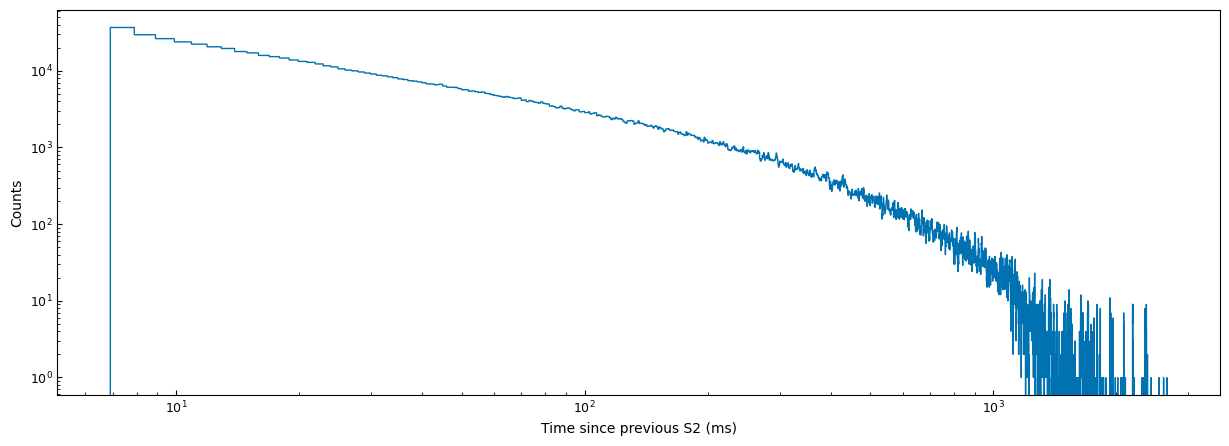

In [17]:
time_diffs_exc_ds_delayed = time_diffs_exc_ds[time_diffs_exc_ds >= 6.9e6]/1e6 

resolution_ms = 1

n_bins = int((np.max(time_diffs_exc_ds_delayed)-np.min(time_diffs_exc_ds_delayed))/resolution_ms)

hist_power_exc_ds, bin_edges_power_exc_ds = np.histogram(time_diffs_exc_ds_delayed, bins=np.linspace(np.min(time_diffs_exc_ds_delayed),
                                                                                                    np.max(time_diffs_exc_ds_delayed),n_bins))
bin_centers_power_exc_ds = (bin_edges_power_exc_ds[:-1] + bin_edges_power_exc_ds[1:])/2

#plotting just to check
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.hist(bin_centers_power_exc_ds,bins=bin_edges_power_exc_ds,weights=hist_power_exc_ds,histtype="step");
ax.set_xlabel("Time since previous S2 (ms)")
ax.set_ylabel("Counts")
ax.set_yscale("log")
ax.set_xscale("log")

In [34]:
c = cost.ExtendedUnbinnedNLL(time_diffs_exc_ds_delayed,power_law_pdf_ext1)
m = Minuit(c,s=9,n=1.38,k=0,t_min=6.9)
m.fixed["t_min"] = True
m.limits["n"] = (1.00001,50)
m.limits["k"] = (0,None)
bin_fit = m.values
#m.interactive()
m.migrad(ncall=500)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.617e+07                 │              Nfcn = 350              │
│ EDM = 5.94e-06 (Goal: 0.0002)    │           time = 36.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │ 1.1368e6  │ 0.0011e6  │            │            │         │         │       │
│ 1 │ n     │  1.4672   │  0.0004   │            │            │ 1.00001 │   50    │       │
│ 2 │ k     │     0     │  0.4e-3   │            │            │    0    │         │       │
│ 3 │ t_min │   6.90    │   0.07    │            │            │         │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────┐
│       │            s            n            k        t_min │
├───────┼─────────────────────────────────────────────────────┤
│     s │     1.14e+06     -0.51e-6 -836.8369e-9            0 │
│     n │     -0.51e-6     1.92e-07      0.3e-12            0 │
│     k │ -836.8369e-9      0.3e-12     3.99e-13            0 │
│ t_min │            0            0            0            0 │
└───────┴─────────────────────────────────────────────────────┘

In [47]:
a = np.load("C:/Users/keert/Downloads/Fit results/powerlaw_fit.npy")
b = np.load("C:/Users/keert/Downloads/Fit results/powerlaw_fit_cov.npy")

[9.06407022e+01 7.30620377e+01 6.03495138e+01 ... 2.36755057e-02
 2.36642277e-02 2.36529592e-02]


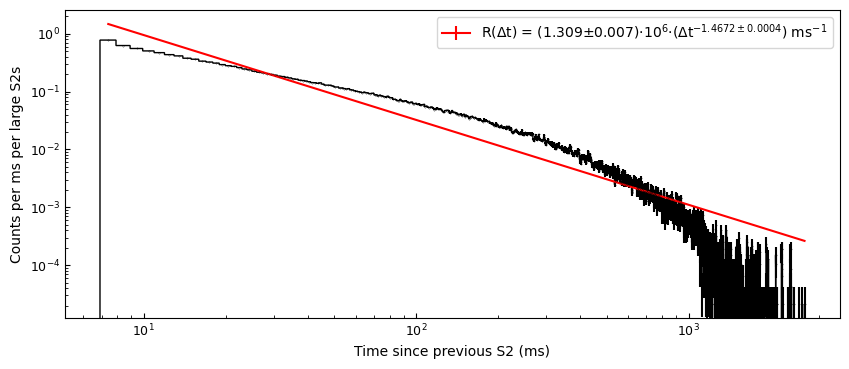

In [54]:
#plotting the fit
fig,ax = plt.subplots(1,1,figsize=(10,4))

def power_model_val(t,p):
    "Just a wrap around function to set the values of the variables"
    s,n,k,t_min = p
    return power_law_pdf_ext1(bin_centers_power_exc_ds,s,n,k,t_min)

#propagating statistical uncertainties in the model to predictions
model, model_errors = propagate(lambda p: power_model_val(bin_centers_power_exc_ds,p)[1],
                                a,b)
model_errors_prop = np.diag(model_errors)**0.5

print(model_errors_prop)
ax.errorbar(bin_centers_power_exc_ds,model/len(s2_peaks_exc_peak1),yerr=model_errors_prop/len(s2_peaks_exc_peak1),color="r"
           ,label=r"R($\Delta$t) = (1.309$\pm$0.007)$\cdot$10$^{6}$$\cdot$($\Delta$t$^{-1.4672\pm0.0004}$) ms$^{-1}$")

ax.set_xlabel("Time since previous S2 (ms)")
ax.set_ylabel("Counts per ms per large S2s")    

ax.hist(bin_centers_power_exc_ds,bins=bin_edges_power_exc_ds,weights=hist_power_exc_ds/(resolution_ms*len(s2_peaks_exc_peak1)),histtype="step",color="k");
ax.errorbar(bin_centers_power_exc_ds,hist_power_exc_ds/(resolution_ms*len(s2_peaks_exc_peak1)),yerr=np.sqrt(hist_power_exc_ds)/(resolution_ms*len(s2_peaks_exc_peak1)),fmt="o",markersize=0.2,color="k")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()


In [21]:
def broken_power_law_pdf(t,s,k,n1, n2, t_min, t_b):
    # Ensure that t is an array for vectorized operations
    t = np.asarray(t)
    x1 = (t_b**(1-n1))/(1-n1)
    x2 = (t_min**(1-n1))/(n1-1) 
    x3 = (t_b**(1-n1))/(n2-1)
    a = 1/(x1+x2+x3)

    def segment1(t):
        pdf1 = np.full(t.shape,0.0)   #did this because otherwise it will calculate the pdf first which is a problem if t=0 is included
        mask = t>=t_min
        pdf1[mask] = a*(t[mask])**(-n1)
        return pdf1
    
    def segment2(t):
        return a*((t_b)**(n2-n1))*((t)**(-n2))
    
    # Apply piecewise function for the CDF
    pdf = np.piecewise(t, 
                       [t < t_b, t >= t_b], 
                       [segment1, segment2])
    
    return s+k*(np.max(t)-t_min),s*pdf+k


In [38]:
#fitting the broken power law pdf
c = cost.ExtendedUnbinnedNLL(time_diffs_exc_ds_delayed,broken_power_law_pdf)
m = Minuit(c,s=len(time_diffs_exc_ds_delayed),k=10,n1=1.3,n2=1.1,
           t_min=6.9,t_b=228)

#fixed because this has been cut from the dataset- smallest possible datapoint
m.fixed["t_min"] = True
m.limits["t_b"] = (6.9,np.max(time_diffs_exc_ds_delayed))

#Limited to zero and above- otherwise it goes to negatives
m.limits["k"] = (0,None)
broken_fit = m.values

m.migrad(ncall=1500)
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.663e+07                 │              Nfcn = 508              │
│ EDM = 0.000417 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │ 1.1368e6  │ 0.0011e6  │            │            │         │         │       │
│ 1 │ k     │     0     │  0.5e-3   │            │            │    0    │         │       │
│ 2 │ n1    │  1.0079   │  0.0010   │            │            │         │         │       │
│ 3 │ n2    │   3.151   │   0.007   │            │            │         │         │       │
│ 4 │ t_min │   6.90    │   0.07    │            │            │         │         │  yes  │
│ 5 │ t_b   │   305.0   │    0.9    │            │            │   6.9   │ 2664.03 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────────────────────────────┐
│       │            s            k           n1           n2        t_min          t_b │
├───────┼───────────────────────────────────────────────────────────────────────────────┤
│     s │     1.14e+06 -6.363949e-6      -0.6e-6     -0.05e-3            0         -0.0 │
│     k │ -6.363949e-6     1.37e-11     0.002e-9     0.126e-9            0     3.737e-9 │
│    n1 │      -0.6e-6     0.002e-9     9.44e-07       1.3e-6            0     444.0e-6 │
│    n2 │     -0.05e-3     0.126e-9       1.3e-6     5.24e-05            0      4.93e-3 │
│ t_min │            0            0            0            0            0          0.0 │
│   t_b │         -0.0     3.737e-9     444.0e-6      4.93e-3          0.0        0.815 │
└───────┴───────────────────────────────────────────────────────────────────────────────┘

In [19]:
a = np.load("C:/Users/keert/Downloads/Fit results/broken_powerlaw_fit.npy")
b = np.load("C:/Users/keert/Downloads/Fit results/broken_powerlaw_fit_cov.npy")

[7.21852145e+01 6.01503223e+01 5.10861083e+01 ... 1.10783753e-02
 1.10677126e-02 1.10570637e-02]


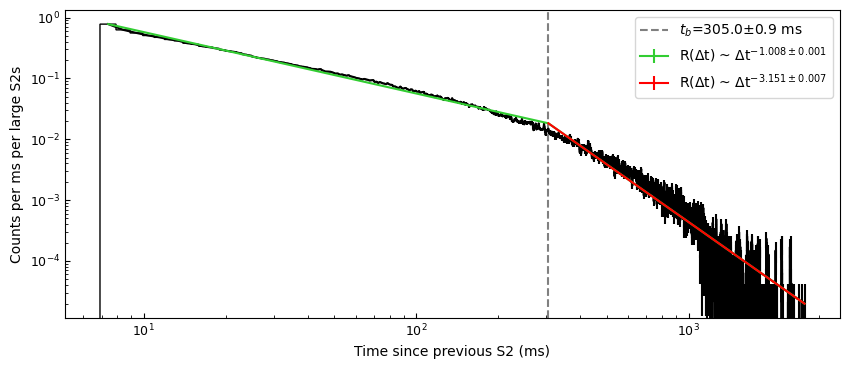

In [23]:
#plotting the fit
fig,ax = plt.subplots(1,1,figsize=(10,4))


def broken_power_model_val(t,p):
    s,k,n1,n2,t_min,t_b = p
    return broken_power_law_pdf(bin_centers_power_exc_ds,s,k,n1,n2,t_min,t_b)

model, model_errors = propagate(lambda p: broken_power_model_val(bin_centers_power_exc_ds,p)[1],
                                a,b)
model_errors_prop = np.diag(model_errors)**0.5

part_2 = bin_centers_power_exc_ds>=a[-1]

print(model_errors_prop)
ax.set_xlabel("Time since previous S2 (ms)")
ax.set_ylabel("Counts per ms per large S2s")    
ax.axvline(x=a[-1],linestyle="--",color="gray",label="$t_b$=305.0$\pm$0.9 ms")

ax.hist(bin_centers_power_exc_ds,bins=bin_edges_power_exc_ds,weights=hist_power_exc_ds/len(s2_peaks_exc_peak1),histtype="step",color="k")
ax.errorbar(bin_centers_power_exc_ds,hist_power_exc_ds/len(s2_peaks_exc_peak1),yerr=np.sqrt(hist_power_exc_ds)/len(s2_peaks_exc_peak1),color="k")
ax.errorbar(bin_centers_power_exc_ds,model/(resolution_ms*len(s2_peaks_exc_peak1)),yerr=model_errors_prop/(resolution_ms*len(s2_peaks_exc_peak1)),color="limegreen",
           label=r"R($\Delta$t) ~ $\Delta$t$^{-1.008\pm0.001}$")
ax.errorbar(bin_centers_power_exc_ds[part_2],model[part_2]/(resolution_ms*len(s2_peaks_exc_peak1)),yerr=model_errors_prop[part_2]/((resolution_ms*len(s2_peaks_exc_peak1)))
           ,label=r"R($\Delta$t) ~ $\Delta$t$^{-3.151\pm0.007}$",color="red")


ax.set_xscale("log")
ax.set_yscale("log")

ax.legend()


# Trying the same thing as above, except not removing double scatters

1135917


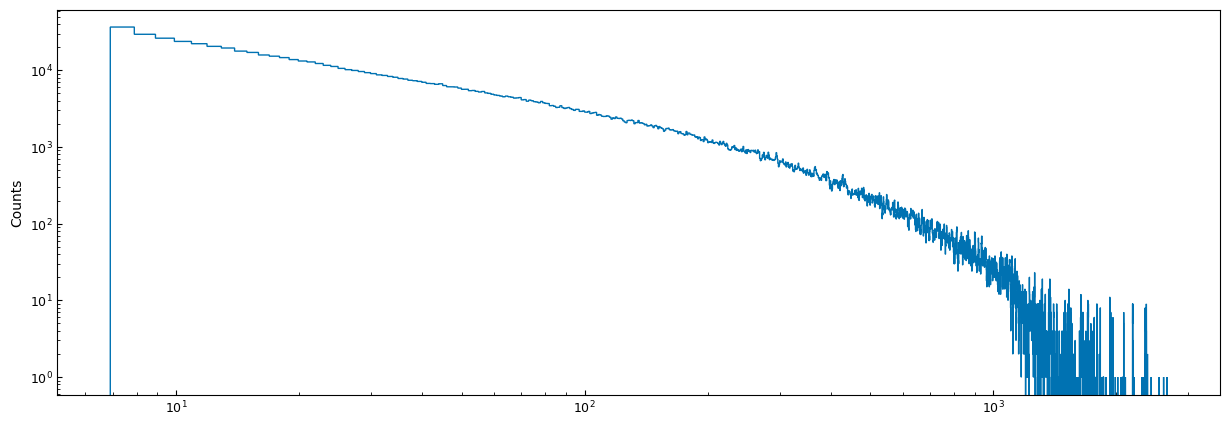

In [155]:
time_to_fit_power = se_delayed_peaks["time differences"]*1e-6

print(len(time_to_fit_power))

resolution_ms = 1

n_bins = int((np.max(time_to_fit_power)-np.min(time_to_fit_power))/resolution_ms)

hist_power, bin_edges_power = np.histogram(time_to_fit_power, bins=np.linspace(np.min(time_to_fit_power),np.max(time_to_fit_power),n_bins))
bin_centers_power = (bin_edges_power[:-1] + bin_edges_power[1:])/2

#plotting just to check
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.hist(bin_centers_power,bins=bin_edges_power,weights=hist_power,histtype="step");
ax.set_ylabel("Counts")
ax.set_xscale("log")
ax.set_yscale("log")


In [156]:
c = cost.ExtendedUnbinnedNLL(time_to_fit_power,power_law_pdf_ext1)
m = Minuit(c,s=9,n=1.38,k=0,t_min=6.9)
m.fixed["t_min"] = True
m.limits["n"] = (1.00001,50)
m.limits["k"] = (0,None)
bin_fit = m.values
#m.interactive()
m.migrad(ncall=500)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.616e+07                 │              Nfcn = 356              │
│ EDM = 0.000149 (Goal: 0.0002)    │           time = 37.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │ 1.1359e6  │ 0.0011e6  │            │            │         │         │       │
│ 1 │ n     │  1.4674   │  0.0004   │            │            │ 1.00001 │   50    │       │
│ 2 │ k     │     0     │  0.4e-3   │            │            │    0    │         │       │
│ 3 │ t_min │   6.90    │   0.07    │            │            │         │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────┐
│       │           s           n           k       t_min │
├───────┼─────────────────────────────────────────────────┤
│     s │    1.14e+06    -0.69e-6 7.764131e-6           0 │
│     n │    -0.69e-6    1.92e-07   -0.003e-9           0 │
│     k │ 7.764131e-6   -0.003e-9     3.5e-11           0 │
│ t_min │           0           0           0           0 │
└───────┴─────────────────────────────────────────────────┘

In [157]:
#fitting the broken power law pdf
c = cost.ExtendedUnbinnedNLL(time_to_fit_power,broken_power_law_pdf)
m = Minuit(c,s=len(time_to_fit_power),k=10,n1=1.3,n2=1.1,
           t_min=6.9,t_b=10)
m.fixed["t_min"] = True
m.limits["n1"] = (1.0001,None)
m.limits["n2"] = (1.0001, None)
m.limits["k"] = (0,None)
m.limits["t_b"] = (10,np.max(time_to_fit_power))
broken_fit = m.values

m.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.662e+07                 │              Nfcn = 546              │
│ EDM = 0.00019 (Goal: 0.0002)     │           time = 63.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │ 1.1359e6  │ 0.0011e6  │            │            │         │         │       │
│ 1 │ k     │     0     │  0.5e-3   │            │            │    0    │         │       │
│ 2 │ n1    │  1.00799  │  0.00015  │            │            │ 1.0001  │         │       │
│ 3 │ n2    │   3.151   │   0.007   │            │            │ 1.0001  │         │       │
│ 4 │ t_min │   6.90    │   0.07    │            │            │         │         │  yes  │
│ 5 │ t_b   │   304.7   │    0.8    │            │            │   10    │ 2664.03 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────────────────────────────┐
│       │            s            k           n1           n2        t_min          t_b │
├───────┼───────────────────────────────────────────────────────────────────────────────┤
│     s │     1.13e+06 -73.96503e-6   299.249e-6   -253.92e-3            0        -22.6 │
│     k │ -73.96503e-6     3.75e-11     -0.01e-9      3.56e-9            0    303.57e-9 │
│    n1 │   299.249e-6     -0.01e-9     2.37e-08    -0.498e-6            0   -66.977e-6 │
│    n2 │   -253.92e-3      3.56e-9    -0.498e-6     5.38e-05            0      4.53e-3 │
│ t_min │            0            0            0            0            0          0.0 │
│   t_b │        -22.6    303.57e-9   -66.977e-6      4.53e-3          0.0          0.6 │
└───────┴───────────────────────────────────────────────────────────────────────────────┘

# Plotting some features

Text(0.5, 1.0, 'Without double scatters')

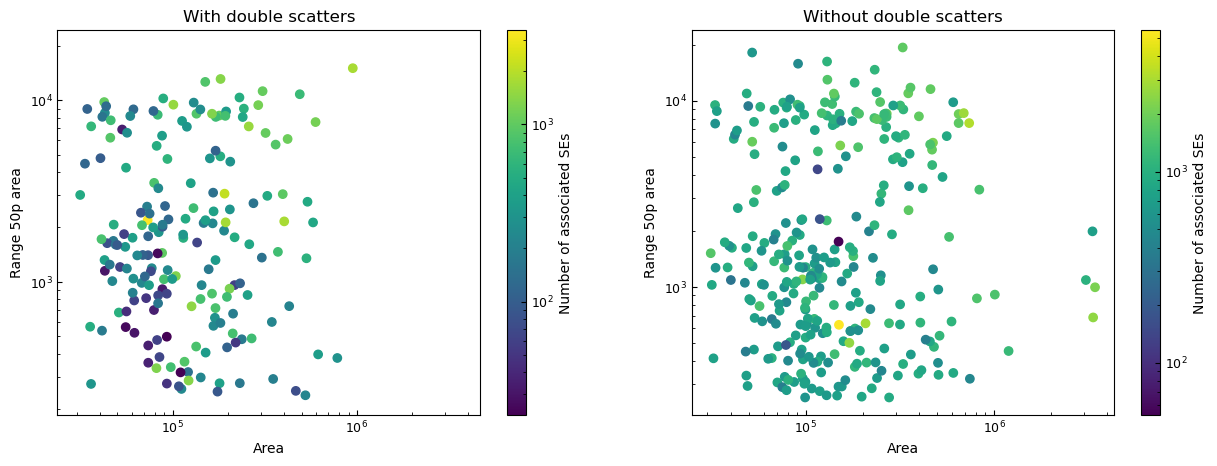

In [160]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

#randomly sample some S2 peaks
x = s2_peaks_assigned.sample(300)
y = s2_peaks_exc_ds.sample(300)

#seeing how SEs change with area and width
scatter1 = ax[0].scatter(x["area"], x["range_50p_area"],
            c=x["SE area total"], cmap='viridis', norm=mcolors.LogNorm())
cbar = plt.colorbar(scatter1,ax=ax[0])
cbar.set_label("Number of associated SEs")
ax[0].set_xlabel("Area")
ax[0].set_ylabel("Range 50p area")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title("With double scatters")

scatter2 = ax[1].scatter(y["area"], y["range_50p_area"],
            c=y["SE area total"], cmap='viridis', norm=mcolors.LogNorm())
cbar = plt.colorbar(scatter2,ax=ax[1])
cbar.set_label("Number of associated SEs")
ax[1].set_xlabel("Area")
ax[1].set_ylabel("Range 50p area")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title("Without double scatters")

#difficult to visualize anything meaningful here. I will instead use plots from the 100s snapshot

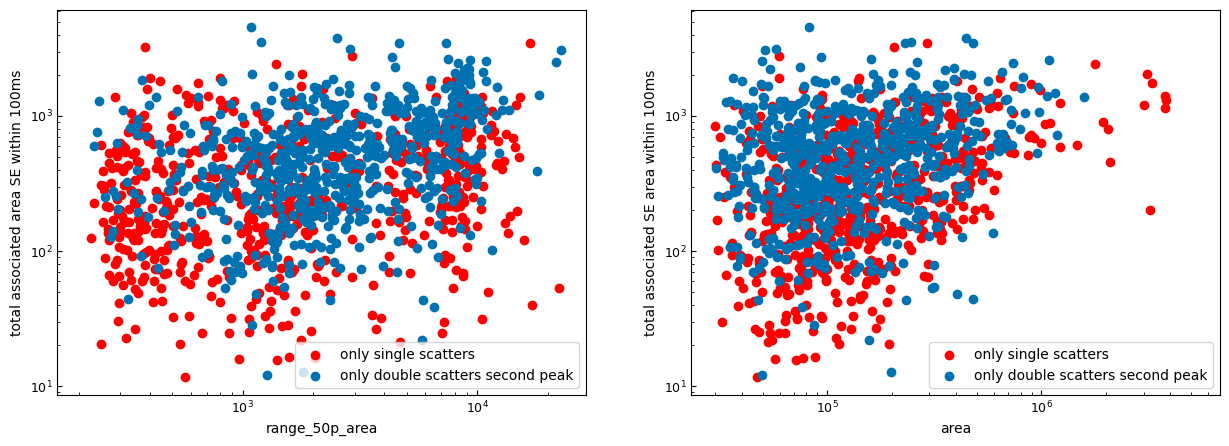

In [66]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

x = s2_peaks_ds_peak2.sample(1000)
y = s2_peaks_exc_ds.sample(700)

#seeing how it is different for single vs. double scatters
ax[0].scatter(y["range_50p_area"],y["SE area total"],label="only single scatters",color="r")
ax[0].scatter(x["range_50p_area"],x["SE area total"],label="only double scatters second peak")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel("range_50p_area")
ax[0].set_ylabel("total associated area SE within 100ms")
ax[0].legend()

ax[1].scatter(y["area"],y["SE area total"],label="only single scatters",color="r")
ax[1].scatter(x["area"],x["SE area total"],label="only double scatters second peak")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel("area")
ax[1].set_ylabel("total associated SE area within 100ms")
ax[1].legend()

#difficult to visualize anything meaningful here. I will instead use plots from the 100s snapshot

In [149]:
#Select data points S2s and the SEs after it for fitting.
#Change indices sliced here to fit/demonstrate the fit!
s2_test_data = s2_peaks_assigned[506:518]
se_test_data = se_delayed_peaks[se_delayed_peaks['S2 index'].isin(s2_test_data.index)]

s2_test_data["time since start"] = (s2_test_data["time"]-s2_test_data["time"].min())
se_test_data_start = (se_test_data["time"]-s2_test_data["time"].min())/1e6

C:\Users\keert\AppData\Local\Temp\ipykernel_19312\2101428725.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s2_test_data["time since start"] = (s2_test_data["time"]-s2_test_data["time"].min())


Text(0, 0.5, 'Counts')

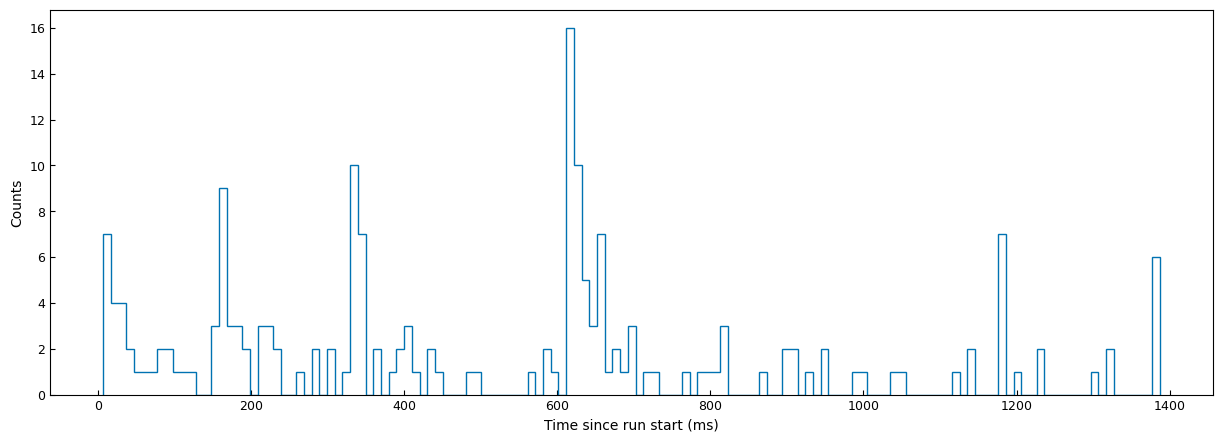

In [150]:
#plotting the single elctrons after the selected peaks just to see
fig,ax = plt.subplots(1,1,figsize=(15,5))

#width of each bin for visualization
resolution_power_sum_ms = 10
n_bins = int((np.max(se_test_data_start)-np.min(se_test_data_start))/resolution_power_sum_ms)

hist_power_sum, bin_edges_power_sum = np.histogram(se_test_data_start, 
                                            bins=np.linspace(np.min(se_test_data_start),
                                                             np.max(se_test_data_start),n_bins))

bin_centers_power_sum = (bin_edges_power_sum[:-1] + bin_edges_power_sum[1:])/2

#adding a marker for location of each S2
ax.hist(bin_centers_power_sum,bins=bin_edges_power_sum,weights=hist_power_sum,histtype="step");
#for x in s2_test_data["time since start"]/1e6:
#    ax.axvline(x,color='r', linestyle='--');

ax.set_xlabel("Time since run start (ms)")
ax.set_ylabel("Counts")
ax.set_ylabel("Counts")

In [82]:
def multiple_power_law_pdf(t, s, a, tmin, s2_peaks,c,d,k):
    """"
    Returns (s, pdf) for a multiple power law model with a single power law component for each S2 peak.

    Arguments:
     - t: array (n_single_electrons), time since first large peak in ms
     - s: float, scale factor, (total amount of single electrons, sum over entire dataset)
     - a: float, power law index
     - tmin: float, minimum time after S2s. Assumes cut has already been applied
     - s2_peaks: dataframe, large S2 peaks
     - c: float, area exponent, determines how differential rate scales with area
     - d: float, width exponent scales differential rate with [width in ms]
    """
     
    # Find time differences of SE peaks w.r.t each S2 peak 
    # shape (n_single_electrons, n_s2s)
    t_all = np.asarray(t[:,None] - s2_peaks["time since start"].values[None,:]/1e6)

    # Keep only differences where the SE is later
    mask = t_all >= tmin
    
    # Evaluate power law for each SE - S2 combination
    # Used np.full since otherwise it will calculate the pdf first 
    # which is a problem if t=0 is included
    pdf_values = np.full_like(t_all,0.0)
    pdf_values[mask] = ((a - 1) / tmin) * (t_all[mask] /tmin) ** (-a)
    
    # Compute total number of SEs contributed by each S2
    # (scales the power law differential rate)
    n = s * np.asarray((s2_peaks["area"].values**c)*((s2_peaks["range_50p_area"].values/1e6)**d))
    differential_rate = np.sum(n*pdf_values,axis=1)
    return n.sum() + k*(np.max(t)-np.min(t)), differential_rate+k

In [80]:
# Fix s2_peak and s2_time, create cost function
def to_fit(t,s,a,tmin,c,d,k):
    s2_peaks = s2_test_data
    return multiple_power_law_pdf(t, s, a, tmin, s2_peaks,c,d,k)

In [20]:
c = cost.ExtendedUnbinnedNLL(np.asarray(se_test_data_start), to_fit)
m = Minuit(c,s=0.5,a=1.1,tmin=6.9,c=1,d=-1,k=0)
m.limits["a"] = (1.0001,5)
m.limits["c"] = (0,5)
m.limits["d"] = (0,5)
m.limits["k"] = (0,100)
m.fixed["tmin"] = True
m.migrad(ncall=2000)
#m.interactive()

#The results below are for the first 2000 peaks from this run

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.717e+05                  │              Nfcn = 929              │
│ EDM = 0.000811 (Goal: 0.0002)    │          time = 1544.5 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s    │  4.81e-3  │  0.32e-3  │            │            │         │         │       │
│ 1 │ a    │   1.448   │   0.005   │            │            │ 1.0001  │    5    │       │
│ 2 │ tmin │   6.90    │   0.07    │            │            │         │         │  yes  │
│ 3 │ c    │   0.880   │   0.004   │            │            │    0    │    5    │       │
│ 4 │ d    │   0.505   │   0.006   │            │            │    0    │    5    │       │
│ 5 │ k    │  36.5e-3  │  0.6e-3   │            │            │    0    │   100   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬─────────────────────────────────────────────────────────────┐
│      │         s         a      tmin         c         d         k │
├──────┼─────────────────────────────────────────────────────────────┤
│    s │  1.04e-07  -0.14e-6         0  -1.04e-6   1.41e-6  -0.02e-6 │
│    a │  -0.14e-6  2.72e-05         0         0  0.001e-3    1.8e-6 │
│ tmin │         0         0         0         0         0         0 │
│    c │  -1.04e-6         0         0  1.42e-05 -0.006e-3    0.1e-6 │
│    d │   1.41e-6  0.001e-3         0 -0.006e-3  3.87e-05    0.4e-6 │
│    k │  -0.02e-6    1.8e-6         0    0.1e-6    0.4e-6  4.16e-07 │
└──────┴─────────────────────────────────────────────────────────────┘

In [78]:
a = np.load("C:/Users/keert/Downloads/Fit results/cumulative_power_law.npy")
b = np.load("C:/Users/keert/Downloads/Fit results/cumulative_power_law_cov.npy")

In [151]:
def cum_power_model_val(t,p):
    s,a,tmin,c,d,k = p
    return to_fit(bin_centers_power_sum,s,a,tmin,c,d,k)

model, model_errors = propagate(lambda p: cum_power_model_val(bin_centers_power_sum,p)[1],
                                a,b)
model_errors_prop = np.diag(model_errors)**0.5


n_val = a[0]*s2_test_data["area"]**a[3]*(s2_test_data["range_50p_area"]/1e6)**a[4]


In [97]:
print(np.sum(n_val)*s)

63587.386677549


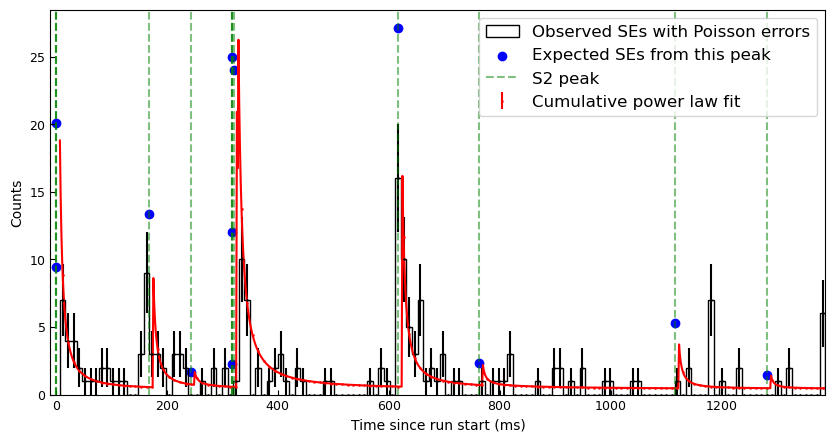

In [152]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(se_test_data_start, bins=bin_edges_power_sum,color="k", histtype='step',label="Observed SEs with Poisson errors")
ax.errorbar(bin_centers_power_sum,hist_power_sum,yerr=np.sqrt(hist_power_sum),fmt="ko",markersize=0.8)

x = np.linspace(np.min(se_test_data_start),np.max(se_test_data_start),1000)
s,p = multiple_power_law_pdf(x,a[0],a[1],a[2],
                             s2_test_data,a[3],a[4],a[5])
ax.errorbar(bin_centers_power_sum,model*resolution_power_sum_ms,yerr=model_errors_prop*resolution_power_sum_ms,fmt="ro",markersize=0.8,label="Cumulative power law fit")
ax.plot(x,p*resolution_power_sum_ms,color="r")
ax.set_xlim(-10,np.max(se_test_data_start))
ax.set_ylabel("Counts")
ax.set_xlabel("Time since run start (ms)")
ax.scatter(s2_test_data["time since start"]/1e6,n_val,color="b",label="Expected SEs from this peak")
for x in s2_test_data["time since start"]/1e6:
    ax.axvline(x,color='green', linestyle='--',alpha=0.5);

ax.axvline(s2_test_data["time since start"].iloc[0]/1e6,color='green', linestyle='--',alpha=0.5,label="S2 peak")
ax.legend(fontsize="large")
